<a href="https://colab.research.google.com/github/diofares/LLM-Estatistica-Atividade3/blob/main/LLM_e_Estatistica_Atividade3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import norm
plt.style.use('ggplot')

              Moeda N_Repeticoes  Surpresa_Media_Simulada  Surpresa_Teorica
0             Justa           10                 1.000000          1.000000
1             Justa          100                 1.000000          1.000000
2             Justa         1000                 1.000000          1.000000
3             90/10           10                 0.152003          0.468996
4             90/10          100                 0.405597          0.468996
5             90/10         1000                 0.459486          0.468996
6  Viesada (p=0.95)           10                 0.498793          0.286397
7  Viesada (p=0.95)          100                 0.328876          0.286397
8  Viesada (p=0.95)         1000                 0.345868          0.286397


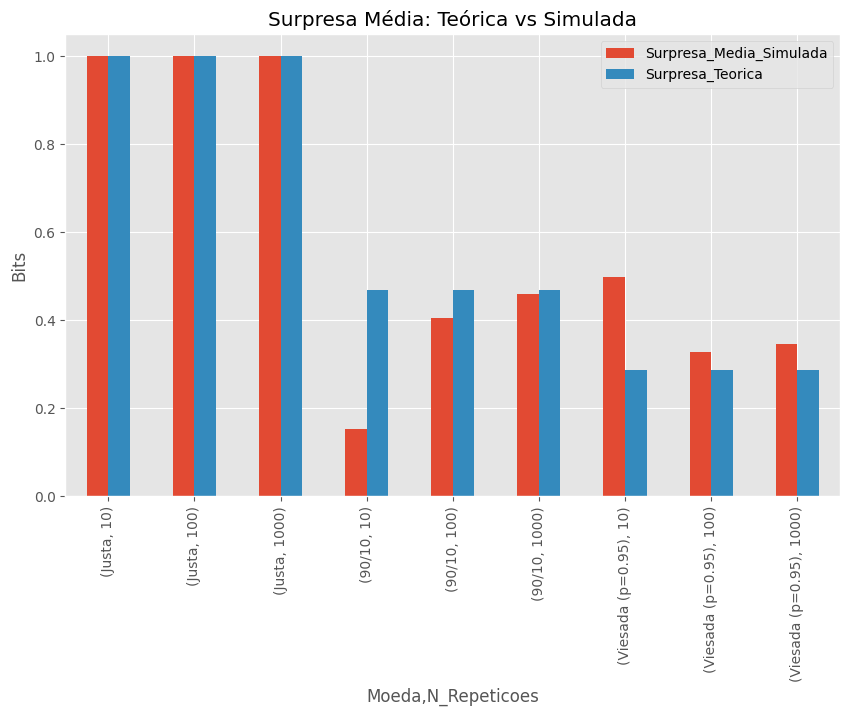

In [3]:
probabilities_map = {'Justa': 0.5, '90/10': 0.9, 'Viesada (p=0.95)': 0.95}
simulation_counts = [10, 100, 1000]

def calculate_surprise(probability):
    return -np.log2(probability)

experiment_results = {'Moeda': [], 'N_Repeticoes': [], 'Surpresa_Media_Simulada': [], 'Surpresa_Teorica': []}
for coin_name, prob_heads in probabilities_map.items():
    prob_tails = 1 - prob_heads
    theoretical_surprise = (prob_heads * calculate_surprise(prob_heads) + prob_tails * calculate_surprise(prob_tails))

    for n_reps in simulation_counts:
        coin_flips = np.random.choice([1, 0], size=n_reps, p=[prob_heads, prob_tails])
        surprises = [calculate_surprise(prob_heads) if flip == 1 else calculate_surprise(prob_tails) for flip in coin_flips]

        experiment_results['Moeda'].append(coin_name)
        experiment_results['N_Repeticoes'].append(str(n_reps))
        experiment_results['Surpresa_Media_Simulada'].append(np.mean(surprises))
        experiment_results['Surpresa_Teorica'].append(theoretical_surprise)

results_df = pd.DataFrame(experiment_results)
print(results_df)

results_df.set_index(['Moeda', 'N_Repeticoes']).plot(kind='bar', figsize=(10, 6))
plt.title("Surpresa Média: Teórica vs Simulada")
plt.ylabel("Bits")
plt.show()

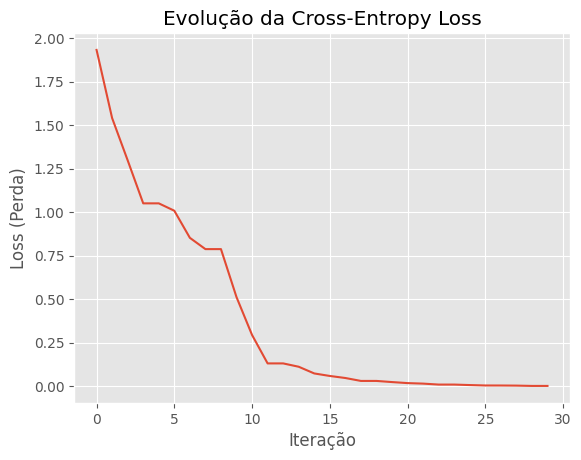

Logits Finais Otimizados:
 [[ 5.32151994 -1.56669529 -1.84443065]
 [-2.31454564  5.02468161 -1.743329  ]
 [-6.34480364 -3.77031917  4.61781036]]


In [4]:
def softmax_function(logits_matrix):
    exp_logits = np.exp(logits_matrix - np.max(logits_matrix, axis=-1, keepdims=True))
    probabilities = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)
    return probabilities

def calculate_cross_entropy(y_true_labels, y_predicted_probs):
    epsilon = 1e-9
    y_predicted_probs = np.clip(y_predicted_probs, epsilon, 1. - epsilon)
    loss = -np.sum(y_true_labels * np.log(y_predicted_probs)) / y_true_labels.shape[0]
    return loss

np.random.seed(int(time.time()))
true_labels_one_hot = np.eye(3)

current_logits = np.random.uniform(0.1, 3.0, (3, 3))
noise_std_dev = 0.5
loss_history = []

for iteration in range(30):
    candidates_list = []

    current_probs = softmax_function(current_logits)
    current_loss = calculate_cross_entropy(true_labels_one_hot, current_probs)
    candidates_list.append((current_logits, current_loss))

    for _ in range(4):
            gaussian_noise = np.random.normal(loc=0, scale=noise_std_dev, size=current_logits.shape)
            perturbed_logits = current_logits + gaussian_noise

            perturbed_probs = softmax_function(perturbed_logits)
            perturbed_loss = calculate_cross_entropy(true_labels_one_hot, perturbed_probs)

            candidates_list.append((perturbed_logits, perturbed_loss))

    candidates_list.sort(key=lambda x: x[1])
    best_candidate_logits = candidates_list[0][0]
    best_candidate_loss = candidates_list[0][1]
    current_logits = best_candidate_logits
    loss_history.append(best_candidate_loss)

plt.plot(loss_history)
plt.title("Evolução da Cross-Entropy Loss")
plt.xlabel("Iteração")
plt.ylabel("Loss (Perda)")
plt.show()

print("Logits Finais Otimizados:\n", current_logits)


In [5]:
prior_probability_spam = 0.4
prior_probability_ham = 0.6

word_conditional_probs = {
    'lunch': {'spam': 0.01, 'ham': 0.4},
    'money': {'spam': 0.8,  'ham': 0.1}
}

def classify_spam_message(message):
    words_in_message = message.lower().split()

    log_prob_spam = np.log(prior_probability_spam)
    log_prob_ham = np.log(prior_probability_ham)

    evidence_table = []

    for word in words_in_message:
        if word in word_conditional_probs:
            p_word_given_spam = word_conditional_probs[word]['spam']
            p_word_given_ham = word_conditional_probs[word]['ham']

            log_prob_spam += np.log(p_word_given_spam)
            log_prob_ham += np.log(p_word_given_ham)

            evidence_table.append({
                'Palavra': word,'P(w|Spam)': p_word_given_spam,'P(w|Ham)': p_word_given_ham
            })

    df_evidence = pd.DataFrame(evidence_table)
    print("Evidências por palavra:\n", df_evidence)

    print(f"\nScore Final (Log) Spam: {log_prob_spam:.4f}")
    print(f"Score Final (Log) Ham:  {log_prob_ham:.4f}")

    if log_prob_spam > log_prob_ham:
        return "SPAM"
    else:
        return "HAM"

input_phrase = "Lunch Money Money Money Money"
classification_result = classify_spam_message(input_phrase)
print(f"\nResultado da Classificação: {classification_result}")

Evidências por palavra:
   Palavra  P(w|Spam)  P(w|Ham)
0   lunch       0.01       0.4
1   money       0.80       0.1
2   money       0.80       0.1
3   money       0.80       0.1
4   money       0.80       0.1

Score Final (Log) Spam: -6.4140
Score Final (Log) Ham:  -10.6375

Resultado da Classificação: SPAM


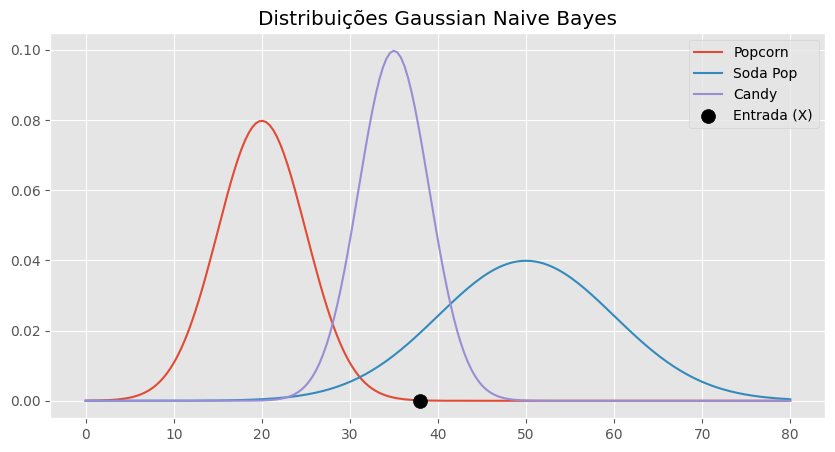

Entrada: 38
Classe Predita: Candy
Probabilidades calculadas: {'Popcorn': np.float64(0.0012905873151598723), 'Soda Pop': np.float64(0.20478286389428055), 'Candy': np.float64(0.7939265487905596)}


In [7]:
class_definitions = {
    'Popcorn':  {'mean': 20, 'std_dev': 5,  'prior': 0.33},
    'Soda Pop': {'mean': 50, 'std_dev': 10, 'prior': 0.33},
    'Candy':    {'mean': 35, 'std_dev': 4,  'prior': 0.33}
}

def calculate_gaussian_likelihood(value, mean, std_dev):
    return norm.pdf(value, loc=mean, scale=std_dev)

def classify_gaussian_input(input_value):
    posterior_scores = {}

    for class_name, params in class_definitions.items():
        likelihood = calculate_gaussian_likelihood(input_value, params['mean'], params['std_dev'])
        prior = params['prior']

        posterior_unnormalized = likelihood * prior
        posterior_scores[class_name] = posterior_unnormalized

    total_score = sum(posterior_scores.values())
    probabilities = {k: v / total_score for k, v in posterior_scores.items()}

    predicted_class = max(probabilities, key=probabilities.get)
    return predicted_class, probabilities

x_values = np.linspace(0, 80, 200)
plt.figure(figsize=(10, 5))

for class_name, params in class_definitions.items():
    y_values = norm.pdf(x_values, params['mean'], params['std_dev'])
    plt.plot(x_values, y_values, label=class_name)

test_value = 38
plt.scatter([test_value], [0], color='black', s=100, label='Entrada (X)', zorder=5)
plt.legend()
plt.title("Distribuições Gaussian Naive Bayes")
plt.show()

predicted_class, class_probabilities = classify_gaussian_input(test_value)

print(f"Entrada: {test_value}")
print(f"Classe Predita: {predicted_class}")
print("Probabilidades calculadas:", class_probabilities)

In [8]:
iris_data = load_iris()
features_X, target_y, class_names = iris_data.data, iris_data.target, iris_data.target_names

naive_bayes_model = GaussianNB()
naive_bayes_model.fit(features_X, target_y)
predictions_y = naive_bayes_model.predict(features_X)

print(f"Acurácia Global: {accuracy_score(target_y, predictions_y):.4f}")
print("\nRelatório:\n", classification_report(target_y, predictions_y, target_names=class_names))

Acurácia Global: 0.9600

Relatório:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.94      0.94      0.94        50
   virginica       0.94      0.94      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



Valor Esperado Teórico Calculado: 0.6526

  Repeticoes  EV_Simulado  EV_Teorico
0         10       0.8000    0.652582
1        100       0.7000    0.652582
2       1000       0.6700    0.652582
3      10000       0.6468    0.652582


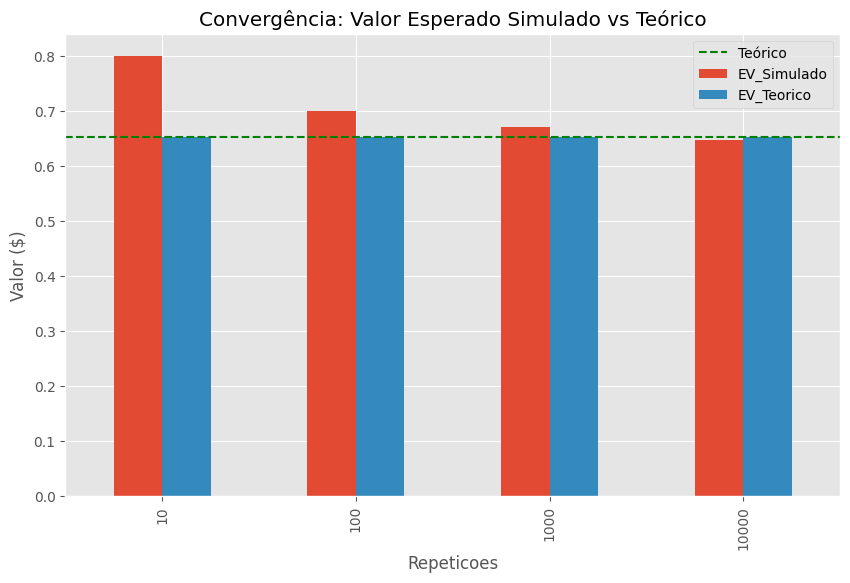

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

population_counts = {'Ouviu falar': 37, 'Nunca ouviu falar': 176}
bet_outcomes = {'Ouviu falar': -1, 'Nunca ouviu falar': 1}

def calculate_expected_value(counts_data, outcomes_data):
    total_people = sum(counts_data.values())
    return sum((count / total_people) * outcomes_data[key] for key, count in counts_data.items())

theoretical_ev = calculate_expected_value(population_counts, bet_outcomes)
simulation_results = {'Repeticoes': [], 'EV_Simulado': [], 'EV_Teorico': []}
event_names = list(population_counts.keys())
event_probs = [count / sum(population_counts.values()) for count in population_counts.values()]

for n_steps in [10, 100, 1000, 10000]:
    random_events = np.random.choice(event_names, size=n_steps, p=event_probs)
    simulation_results['Repeticoes'].append(str(n_steps))
    simulation_results['EV_Simulado'].append(np.mean([bet_outcomes[event] for event in random_events]))
    simulation_results['EV_Teorico'].append(theoretical_ev)

df_results = pd.DataFrame(simulation_results)
print(f"Valor Esperado Teórico Calculado: {theoretical_ev:.4f}\n")
print(df_results)

df_results.set_index('Repeticoes').plot(kind='bar', figsize=(10, 6))
plt.title("Convergência: Valor Esperado Simulado vs Teórico")
plt.ylabel("Valor ($)")
plt.axhline(y=theoretical_ev, color='green', linestyle='--', label='Teórico')
plt.legend()
plt.show()